# Imports

In [175]:
! pip install StackApi

In [176]:
import ast
from datetime import datetime
from calendar import monthrange

import requests

import pickle
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

from nltk.corpus import stopwords
import spacy
from bs4 import BeautifulSoup
import re

from stackapi import StackAPI


with open("lda_model.pkl", "rb") as f:
    lda = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)


nlp = spacy.load("en_core_web_sm")

TAGS = list(label_encoder.classes_)
YEAR = 2017

# Utils

In [177]:
def get_posts_by_tag_month(tag, month, pagesize=50):
    base_url = "https://api.stackexchange.com/2.3/questions"

    from_date = int(datetime(YEAR, month, 1, 0, 0, 0).timestamp())

    last_day = monthrange(YEAR, month)[1]
    to_date   = int(datetime(YEAR, month, last_day, 23, 59, 59).timestamp())

    params = {
        "order": "desc",
        "sort": "activity",
        "tagged": tag,
        "site": "stackoverflow",
        "filter": "withbody",
        "pagesize": pagesize,
        "fromdate": from_date,
        "todate": to_date
    }
    
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get("items", [])
    else:
        print(f"Error {response.status_code} when collecting posts for the tag '{tag}'")
        return []
    

In [178]:
def cleaning(text):
    set_stopwords = set(stopwords.words("english"))

    text = BeautifulSoup(text).get_text()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    
    doc = nlp(text)
    meaningful_words = [w.lemma_ for w in doc if not str(w) in set_stopwords]   

    return( " ".join(meaningful_words)) 


In [179]:
def extract_dataset_month(month):
    print(f"Month: {month}")

    l_tags, l_text = [], []
    for tag in TAGS:
        posts = get_posts_by_tag_month(tag, month)
        for post in posts:
            l_tags.append(post["tags"])

            text = post["title"] + post["body"]
            l_text.append(cleaning(text))
    
    res = pd.DataFrame({"tags": l_tags, "text": l_text})   
    res["tags"] = res["tags"].apply(lambda x: list(set(x) & set(TAGS)))

    return res    

# Request StackOverflow API

In [180]:
pd.read_csv(f"data/dataset_{YEAR}-{9}.csv").head()

,Unnamed: 0,tags,text
0,0,['android'],searchview listview change item position nee...
1,1,['android'],android google map marker correct face rotatio...
2,2,"['android', 'java']",error inflate class emojipalettesview latinime...
3,3,['android'],install android sdk user silently window andro...
4,4,['android'],send string int datum bluetooth arduinoi ne...


In [181]:
SITE = StackAPI('stackoverflow')


dataframes = {}
for month in range(8,9):
    dataframes[month] = extract_dataset_month(month)
    dataframes[month].to_csv(f"data/dataset_{YEAR}-{month}.csv")

Month: 8


# Prepare the datasets for the simulation

In [182]:
dataframes = {}
for month in range(1, 13):
    if month != 8:
        dataframes[month] = pd.read_csv(f"data/dataset_{YEAR}-{month}.csv")
        dataframes[month]["tags"] = dataframes[month]["tags"].apply(lambda x: ast.literal_eval(x)[0])

# Simulation

In [183]:
l_f1_score = []

for month in range(1, 13):
    if month != 8:
        df = dataframes[month]
        X = vectorizer.transform(df["text"]).toarray()
        Y_pred = lda.predict(X)
        Y = df["tags"]
        l_f1_score.append(f1_score(Y, Y_pred, average='weighted'))

# Display results

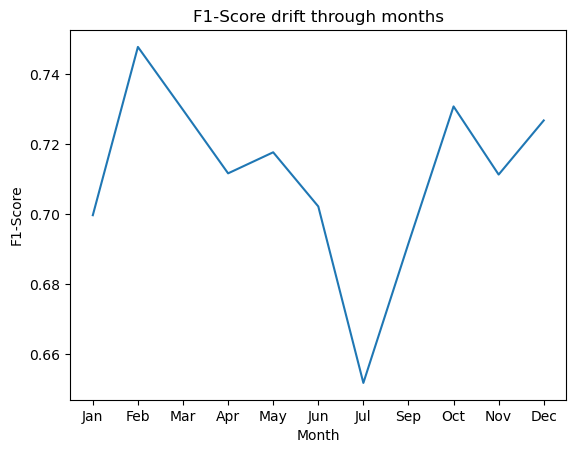

In [184]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure()

plt.title("F1-Score drift through months")
plt.xlabel("Month")
plt.ylabel("F1-Score")

plt.plot([months[i-1] for i in range(1, 8)] + [months[i-1] for i in range(9,13)], l_f1_score)

plt.show()